<h3 align="center">Computational Problem Set 7</h3> 

<h4 align="center">Kaitlyn Morrell</h4> 

In [1]:
# -*- coding: utf-8 -*-
%pylab notebook --no-import-all
%matplotlib notebook
import numpy as np
import sympy as sp
from sympy import *
import numpy.linalg as linalg
import scipy.sparse as sparse
from matplotlib import animation
from matplotlib.collections import LineCollection
from IPython.display import HTML

sp.init_printing(use_latex=True, use_unicode=True)

#from __future__ import division #don't need to distinguish floats from integers for division

Populating the interactive namespace from numpy and matplotlib


### Separation of Variables

We can use the method of separation of variables to analytically solve the differential equation $$\partial_t u(x,t) - \alpha\partial^2_x u(x,t) = 0 $$ by noting $$u(x,t) = v(t)w(x)$$ which gives $$\partial_t u(x,t) = \dot{v}w(x) \text{  and  } \partial^2_x u(x,t) = w^{''}v(t) $$ Plugging this into our initial equation gives $$\dot{v}w(x)-\alpha w^{''}v(t) = 0$$ $$\dot{v}w = \alpha w^{''}v$$ $$\frac{\dot{v}}{v} = \alpha\frac{w^{''}}{w}$$ We can solve for $v(t)$ and $w(x)$ by noticing that varying $t$ cannot change the right hand side and varying $x$ cannot change the left hand side. This implies $$\frac{\dot{v}}{v} = - c $$ $$\partial_t(\ln v(t)) = - c$$ $$\ln v(t) = - ct + K$$ $$v(t) = Ae^{- ct}$$  where $c$, $K$, and $A$ are constants that depend on initial conditions. Likewise, we can find an equation for $w(x)$: $$\alpha \frac{w^{''}}{w} = -c$$ $$w^{''} = -\frac{c}{\alpha}w$$ This is a familiar differential equation so we will assume the ansatz $w = B\cos(x\sqrt{c/\alpha})$ and find: $$w^{''} = -\frac{c}{\alpha}B\cos(x\sqrt{c/\alpha}) = -\frac{c}{\alpha}w$$ where $B$ and $c$ are constants determined by the boundary conditions. We can apply the boundary condition $\partial_x u(0,t)=\partial_x u(L,t) = 0$ where $L$ is the length of the rod: $$\partial_x u(L,t) = w' = -B\sin(L\sqrt{c/\alpha}) = 0$$ Assuming $B\neq 0$ $$L\sqrt{c/\alpha} = n\pi$$ $$c=\frac{n^2\pi^2\alpha}{L^2}$$. Combining solutions into one equation gives: $$u(x,t) = Ae^{-\frac{n^2\pi^2\alpha}{L^2}t}\cos(x\frac{n\pi}{L})$$

### Finite Difference Method

In [87]:
class HeatProb():
    """Class for setting up a heat equation eigenvector problem"""
    def alpha(self, x=None):
        """Return alpha at x"""
        return(1.) 
    def __init__(self, N=201, L=np.pi, **kwargs): #can put any initial inputs when call class
        self.kwargs = kwargs
        self.N = N
        self.L = L
        self.h = L / (np.float64(N) )
        self.x = (np.arange(self.N, dtype=np.float64) ) * self.h
        diagonal = 2. * np.ones(len(self.x))
        lower_diagonal = -1 * np.ones(len(self.x))
        upper_diagonal = -1 * np.ones(len(self.x))
        lower_diagonal[-2] = upper_diagonal[0] = -2
        self.A = (self.alpha(self.x) / self.h**2) * sparse.diags(diagonals=[lower_diagonal, diagonal, upper_diagonal],
                              offsets=[-1, 0, 1], shape=(N, N))
    def eig(self):
        vals, vecs = linalg.eig(self.A.toarray())
        isort = np.argsort(vals)
        self.evals = vals[isort]
        self.evecs = vecs[:, isort]
    def set_coeffs(self, a=None):
        self.a = a
    def fit_coeffs(self, d=None):
        """Fit coefficients for eigenvectors for a set of displacements"""
        (u, w, vt) = linalg.svd(self.evecs)
        inz = np.where(w > 1.e-15)[0]
        invw = np.zeros(len(w))
        invw[inz] = 1. / w[inz] 
        einv = vt.T.dot(np.diag(invw)).dot(u.T)
        return(einv.dot(d)) 
    def stream(self, nframes = 200):
        
        fig, ax = plt.subplots()

        ax.set_xlim([ -0.1, self.L])
        ax.set_ylim([- 1, 1])
        
        plt.ioff()
        line, = ax.plot([], [], lw=2);
        
        def first():
            line.set_data([], [])
            return (line,)
        
        def frame(i):
            period =  2. # np.pi / np.sqrt(self.evals[0])
            t = np.float64(i) / np.float64(nframes) * period
            x = self.x
            coeffs = (self.a * np.exp(-self.evals * t) )
            y = self.evecs.dot(coeffs).flatten()
            line.set_data(x, y)
            return (line,)
        
        anim = animation.FuncAnimation(fig, frame, init_func=first,
                               frames=nframes, interval=40, blit=True)
        
        plt.close(fig)
        return anim

In [88]:
ht = HeatProb()
ht.eig()

<IPython.core.display.Javascript object>


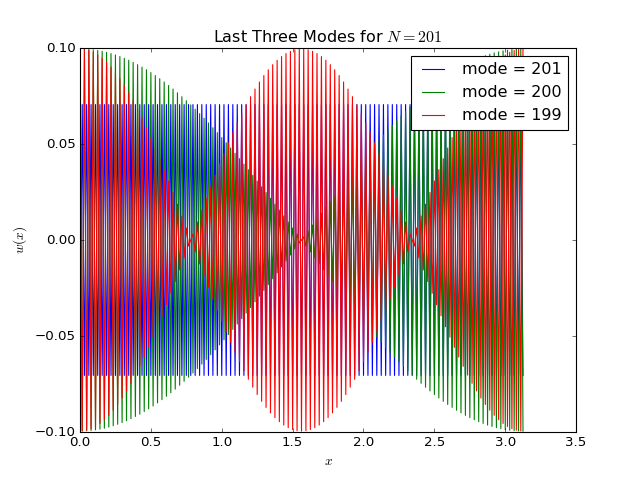

In [89]:
plt.figure()
for i in np.arange(3)+1:
    plt.plot(ht.x, ht.evecs[:, -i], label='mode = %d' % (201-i+1))
plt.legend()
plt.title('Last Three Modes for $N=%d$'% (201))
plt.xlabel('$x$')
plt.ylabel('$w(x)$')
plt.show()

Since these are enveloped cosine waves, I see that they agree with my analytic solution.

To investigate how the accuracy of the finite difference method varies with $N$, I compute the eigenvectors for various values of $N$ and plot a range of the resulting modes.

In [90]:
Ns = np.array([10, 70, 150, 200, 500])

In [91]:
ht1 = HeatProb(Ns[0])
ht1.eig()
ht2 = HeatProb(Ns[1])
ht2.eig()
ht3 = HeatProb(Ns[2])
ht3.eig()
ht4 = HeatProb(Ns[3])
ht4.eig()
ht5 = HeatProb(Ns[4])
ht5.eig()

<IPython.core.display.Javascript object>


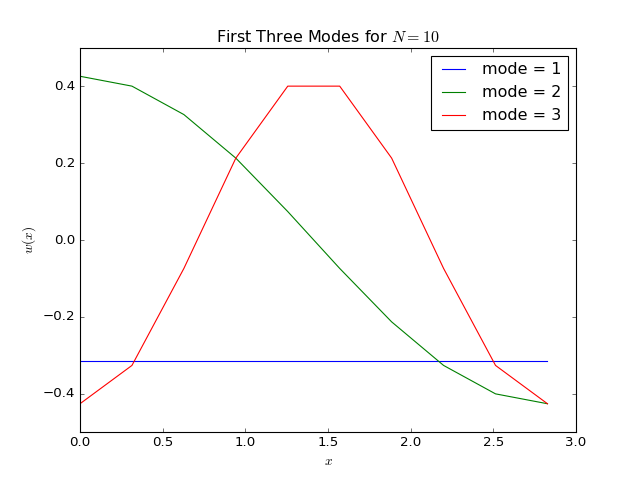

<IPython.core.display.Javascript object>


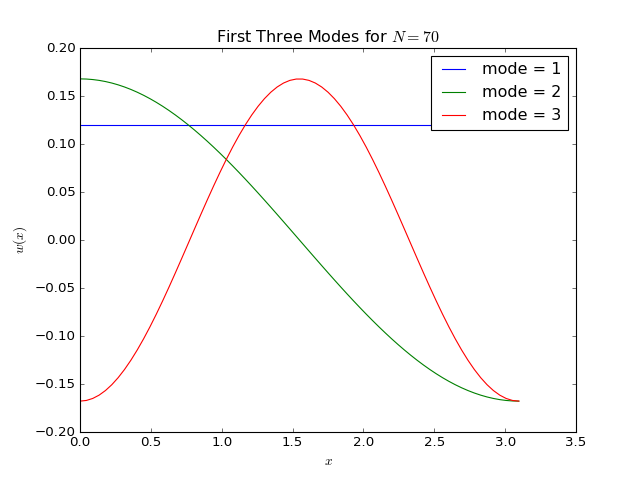

<IPython.core.display.Javascript object>


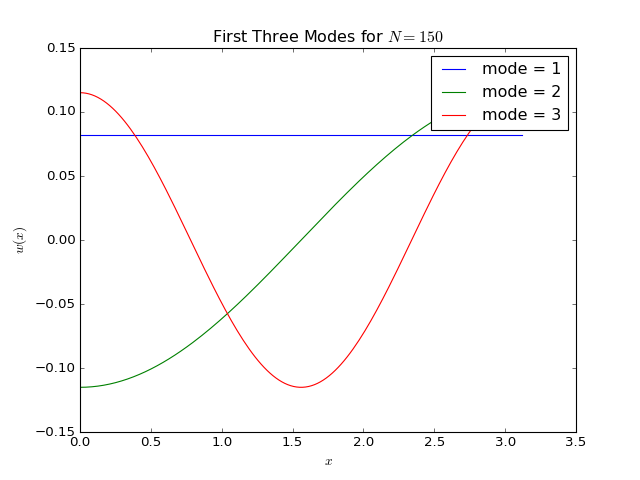

<IPython.core.display.Javascript object>


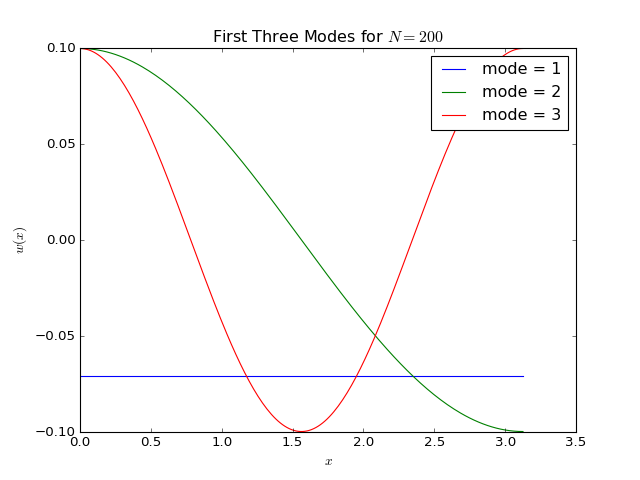

<IPython.core.display.Javascript object>


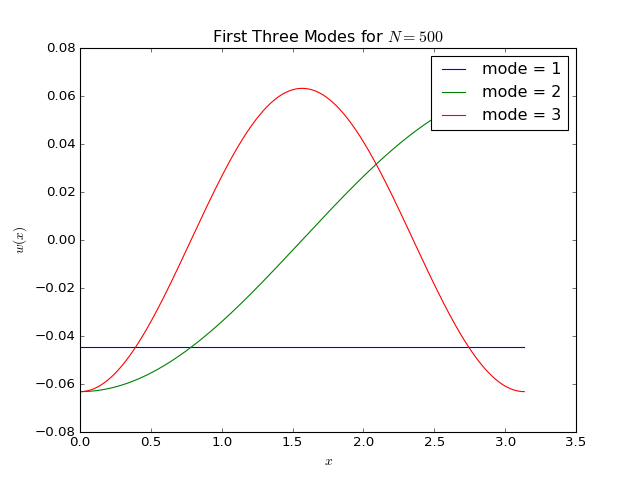

In [98]:
plt.figure()
for i in np.arange(3):
    plt.plot(ht1.x, ht1.evecs[:, i], label='mode = %d' % (i+1))
plt.legend()
plt.title('First Three Modes for $N=%d$'% (Ns[0]))
plt.xlabel('$x$')
plt.ylabel('$w(x)$')
plt.figure()
for i in np.arange(3):
    plt.plot(ht2.x, ht2.evecs[:, i], label='mode = %d' % (i+1))
plt.legend()
plt.title('First Three Modes for $N=%d$'% (Ns[1]))
plt.xlabel('$x$')
plt.ylabel('$w(x)$')
plt.figure()
for i in np.arange(3):
    plt.plot(ht3.x, ht3.evecs[:, i], label='mode = %d' % (i+1))
plt.legend()
plt.title('First Three Modes for $N=%d$'% (Ns[2]))
plt.xlabel('$x$')
plt.ylabel('$w(x)$')
plt.figure()
for i in np.arange(3):
    plt.plot(ht4.x, ht4.evecs[:, i], label='mode = %d' % (i+1))
plt.legend()
plt.title('First Three Modes for $N=%d$'% (Ns[3]))
plt.xlabel('$x$')
plt.ylabel('$w(x)$')
plt.figure()
for i in np.arange(3):
    plt.plot(ht5.x, ht5.evecs[:, i], label='mode = %d' % (i+1))
plt.legend()
plt.title('First Three Modes for $N=%d$'% (Ns[4]))
plt.xlabel('$x$')
plt.ylabel('$w(x)$')
plt.show()

<IPython.core.display.Javascript object>


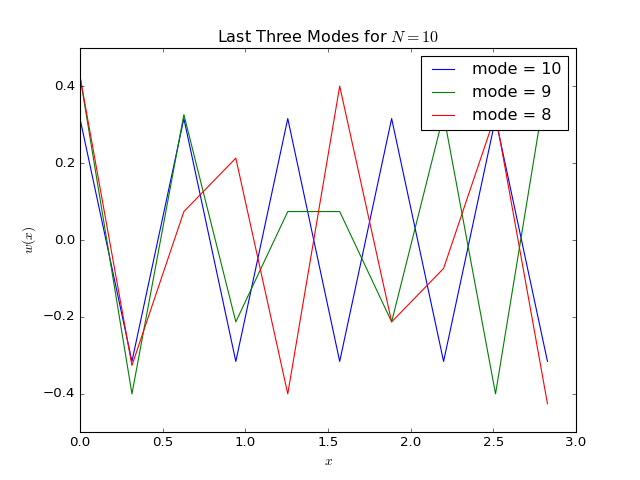

<IPython.core.display.Javascript object>


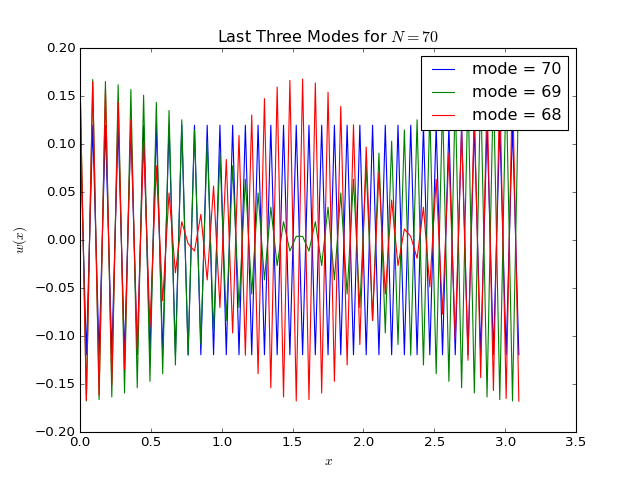

<IPython.core.display.Javascript object>


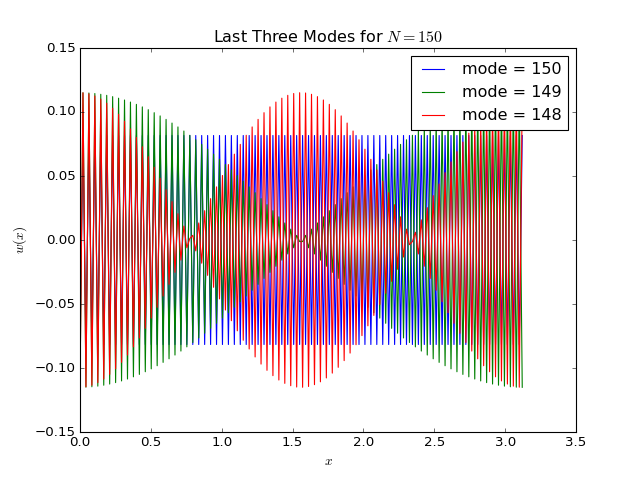

<IPython.core.display.Javascript object>


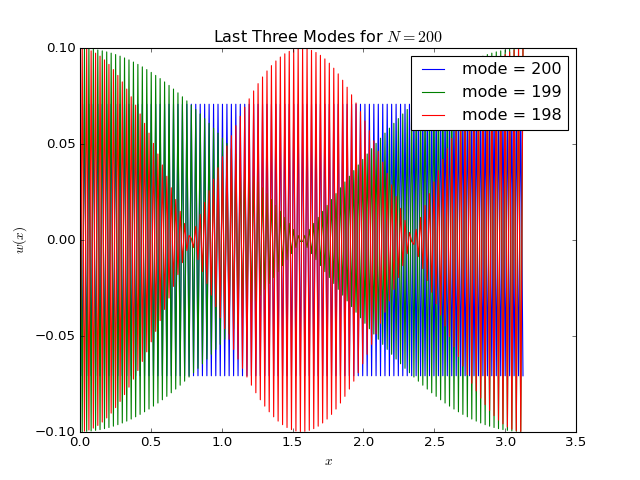

<IPython.core.display.Javascript object>


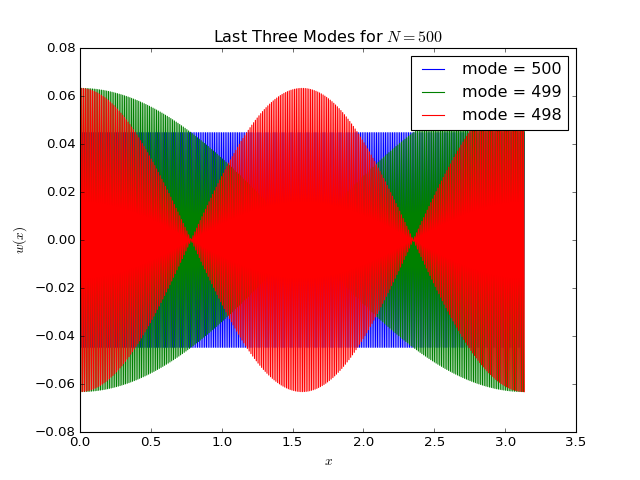

In [99]:
plt.figure()
for i in np.arange(3)+1:
    plt.plot(ht1.x, ht1.evecs[:, -i], label='mode = %d' % (Ns[0]-i+1))
plt.legend()
plt.title('Last Three Modes for $N=%d$'% (Ns[0]))
plt.xlabel('$x$')
plt.ylabel('$w(x)$')
plt.figure()
for i in np.arange(3)+1:
    plt.plot(ht2.x, ht2.evecs[:, -i], label='mode = %d' % (Ns[1]-i+1))
plt.legend()
plt.title('Last Three Modes for $N=%d$'% (Ns[1]))
plt.xlabel('$x$')
plt.ylabel('$w(x)$')
plt.figure()
for i in np.arange(3)+1:
    plt.plot(ht3.x, ht3.evecs[:, -i], label='mode = %d' % (Ns[2]-i+1))
plt.legend()
plt.title('Last Three Modes for $N=%d$'% (Ns[2]))
plt.xlabel('$x$')
plt.ylabel('$w(x)$')
plt.figure()
for i in np.arange(3)+1:
    plt.plot(ht4.x, ht4.evecs[:, -i], label='mode = %d' % (Ns[3]-i+1))
plt.legend()
plt.title('Last Three Modes for $N=%d$'% (Ns[3]))
plt.xlabel('$x$')
plt.ylabel('$w(x)$')
plt.figure()
for i in np.arange(3)+1:
    plt.plot(ht5.x, ht5.evecs[:, -i], label='mode = %d' % (Ns[4]-i+1))
plt.legend()
plt.title('Last Three Modes for $N=%d$'% (Ns[4]))
plt.xlabel('$x$')
plt.ylabel('$w(x)$')
plt.show()

I can see that for low values of $N$, the finite difference eigenfunctions are less accurate than for larger $N$. This is is shown by the more pointed, less continuous functions for small $N$.

How does a central temperature excess evolve in time?

<IPython.core.display.Javascript object>


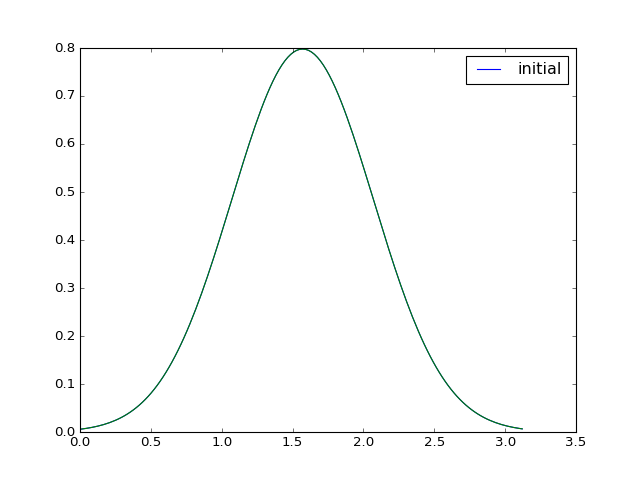

In [100]:
initial = mlab.normpdf(ht3.x, ht3.L / 2., 0.5)
coeffs = ht3.fit_coeffs(d=initial)
plt.figure()
plt.plot(ht3.x, initial, label='initial')
plt.plot(ht3.x, ht3.evecs.dot(coeffs))
plt.legend()
plt.show()

In [101]:
ht3.set_coeffs(a=coeffs)
vid = ht3.stream()
HTML(vid.to_html5_video())